For later: 
- this is no account for trades made between seasons or during seasons
- normalizing the pbp arrats made the difference between always predicting wins and actually having variation

In [1]:
import datetime
import string
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from basketball_reference_scraper.pbp import get_pbp
from basketball_reference_scraper.constants import TEAM_TO_TEAM_ABBR
from basketball_reference_scraper.seasons import get_schedule

In [2]:
#  Indexing pbp dataframe
QTR_IDX = 0
TIME_IDX = 1
HOME_IDX = 2
AWAY_IDX = 3

#  Indexing numpy array "plays"
TEAM_IDX = 0
TIME_IDX = 1
SCOREPLAY_IDX = 2
BENEFIT_IDX = 3
DETRIMENT_IDX = 4
MOMENTUM_IDX = 5

results = ['LOSS','WIN']

In [3]:
def shuffle_arrays(a, b, c=None):
    assert len(a) == len(b) and len(b) == len(c)
    p = np.random.permutation(len(a))
    a = [a[i] for i in p]
    b = [b[i] for i in p]
    c = [c[i] for i in p]
    
    return a, b, c

def name_to_abbr(team):
    return TEAM_TO_TEAM_ABBR[team.upper()]

def calculate_elapsed_time(remaining, quarter):
    qtr = '12:00.0' # 12-minute regulation quarters
    ot = '5:00.0'  # 5-minute overtime periods
    format = '%M:%S.%f'

    if 'OT' not in str(quarter): #  play occurs during regulation
        period = qtr
        quarter_progression = datetime.timedelta(minutes=(quarter-1)*12) 
    else: #  play occurs during overtime
        period = ot
        ot_period = int(quarter.strip(string.ascii_letters))
        quarter_progression = datetime.timedelta(minutes=(ot_period-1)*5)  
        
    return (quarter_progression + 
            datetime.datetime.strptime(period, format) - 
            datetime.datetime.strptime(remaining, format))

# def penalty_play(play):
#     results = ['foul']

def scoring_play(play):
    results = ['makes 2-pt', 'makes 3-pt']
    if any(word in play for word in results):
        return 1
    return 0
    
def benifit_play(play):
    results = ['rebound', 'foul']
    if any(word in play for word in results):
        return 1
    return 0

def detriment_play(play):
    results = ['turnover', 'miss', 'timeout']
    if any(word in play for word in results):
        return 1
    return 0
    
def process_play(time, play):
    return np.array([time, scoring_play(play), benifit_play(play), detriment_play(play)])

def calculate_momentum(play_arr):
    return (1+play_arr[SCOREPLAY_IDX]) * (1+play_arr[BENEFIT_IDX]) - 2*play_arr[DETRIMENT_IDX]
    
def momentum_checks(plays):
    playcount = plays.shape[0]
    
    for play in range(playcount):
        idx = play  # start from the current play
        while idx >= 0:
            idx -= 1
            if plays[play][TIME_IDX] - plays[idx][TIME_IDX] > 60:
                break
            plays[play][MOMENTUM_IDX] += calculate_momentum(plays[idx])

    return plays

In [4]:
year = 2021
# team = 'Los Angeles Clippers'
team = 'Brooklyn Nets'

#  Get the nba schedule (all games)
nba = get_schedule(year, playoffs=False)

#  Remove games that have not yet been played
season = nba[~np.isnan(nba.VISITOR_PTS)]
season = nba[~np.isnan(nba.HOME_PTS)]

#  Select games played by a specific team if desired
team_season = pd.concat((season[season.VISITOR == team], season[season.HOME== team]), axis=0)


In [5]:
games_pbp = []
wins = []
game_summaries = []

playcount_stopper = 300

#  Extract parameters used by play-by-play functions 
for idx,row in team_season.iterrows():
    date = row['DATE']
    away = name_to_abbr(row['VISITOR'])
    home = name_to_abbr(row['HOME'])
    home_winner = row['HOME_PTS'] > row['VISITOR_PTS']
    winner = home if home_winner else away
    
    summary = f'{date.date()}: {away} @ {home} | winner: {winner}'
    game_summaries.append(summary)
    print(summary)
    
    wins.append(1 if winner == name_to_abbr(team) else 0)
    
    #  Begin processing play-by-play data on a per-game basis
    pbp = get_pbp(date, home, away)
    pbp_playcount = len(pbp)

    # Stop collecting pbp data after n plays (comment this line to use the full pbp data) 
    pbp_playcount = playcount_stopper

    
    plays = np.zeros((pbp_playcount, 6))  # HOME?, time (secs), score, benefit, detriment, momentum_score    
    
    for play in range(pbp_playcount):
        elapsed_gametime = calculate_elapsed_time(pbp.iloc[play][TIME_IDX], pbp.iloc[play][QTR_IDX])
        action_home = pbp.iloc[play][HOME_IDX]
        action_away = pbp.iloc[play][AWAY_IDX]

        if action_home is not np.nan:
            plays[play] = np.hstack((1, process_play(elapsed_gametime.seconds, action_home.lower()), 0))
        else:
            plays[play] = np.hstack((0, process_play(elapsed_gametime.seconds, action_away.lower()), 0))

    plays = momentum_checks(plays)
    plays = plays / plays.max(axis=0)
    
    games_pbp.append(plays)

2020-12-25: BRK @ BOS | winner: BRK
2020-12-27: BRK @ CHO | winner: CHO
2021-01-08: BRK @ MEM | winner: MEM
2021-01-13: BRK @ NYK | winner: BRK
2021-01-20: BRK @ CLE | winner: CLE
2021-01-22: BRK @ CLE | winner: CLE
2021-01-27: BRK @ ATL | winner: BRK
2021-01-29: BRK @ OKC | winner: BRK
2021-01-31: BRK @ WAS | winner: WAS
2021-02-06: BRK @ PHI | winner: PHI
2021-02-09: BRK @ DET | winner: DET
2021-02-13: BRK @ GSW | winner: BRK
2021-02-15: BRK @ SAC | winner: BRK
2021-02-16: BRK @ PHO | winner: BRK
2021-02-18: BRK @ LAL | winner: BRK
2021-02-21: BRK @ LAC | winner: BRK
2021-03-01: BRK @ SAS | winner: BRK
2021-03-03: BRK @ HOU | winner: BRK
2021-03-17: BRK @ IND | winner: BRK
2021-03-19: BRK @ ORL | winner: ORL
2021-03-23: BRK @ POR | winner: BRK
2021-03-24: BRK @ UTA | winner: UTA
2021-03-26: BRK @ DET | winner: BRK
2021-04-04: BRK @ CHI | winner: CHI
2021-04-13: BRK @ MIN | winner: BRK
2021-04-14: BRK @ PHI | winner: PHI
2021-04-18: BRK @ MIA | winner: MIA
2021-04-20: BRK @ NOP | winn

In [6]:
print(np.array(games_pbp).shape)
game_count = len(games_pbp)

games_pbp, wins, game_summaries = shuffle_arrays(np.array(games_pbp), np.array(wins), game_summaries)

tts_idx = round(game_count*0.75)  # train-test-split index

X_train = np.array(games_pbp)[:tts_idx].reshape(tts_idx,-1)
y_train = np.array(wins)[:tts_idx].reshape(-1,)

X_test = np.array(games_pbp)[tts_idx:].reshape(game_count-tts_idx,-1)
y_test = np.array(wins)[tts_idx:].reshape(-1,)

(84, 300, 6)


h=(2000, 1) | accuracy = 52.38095238095239

2021-05-16: CLE @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-03-19: BRK @ ORL | winner: ORL ||| Prediction: BRK WIN
2021-01-03: WAS @ BRK | winner: WAS ||| Prediction: BRK WIN
2021-04-18: BRK @ MIA | winner: MIA ||| Prediction: BRK WIN
2021-04-30: POR @ BRK | winner: POR ||| Prediction: BRK WIN
2021-04-29: BRK @ IND | winner: BRK ||| Prediction: BRK WIN
2021-01-08: BRK @ MEM | winner: MEM ||| Prediction: BRK WIN
2021-04-23: BOS @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-03-17: BRK @ IND | winner: BRK ||| Prediction: BRK WIN
2021-02-13: BRK @ GSW | winner: BRK ||| Prediction: BRK WIN
2021-05-04: BRK @ MIL | winner: MIL ||| Prediction: BRK WIN
2021-03-01: BRK @ SAS | winner: BRK ||| Prediction: BRK WIN
2021-04-07: NOP @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-04-16: CHO @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-05-12: SAS @ BRK | winner: BRK ||| Prediction: BRK WIN
2020-12-28: MEM @ BRK | winner: MEM ||| Prediction: BRK 

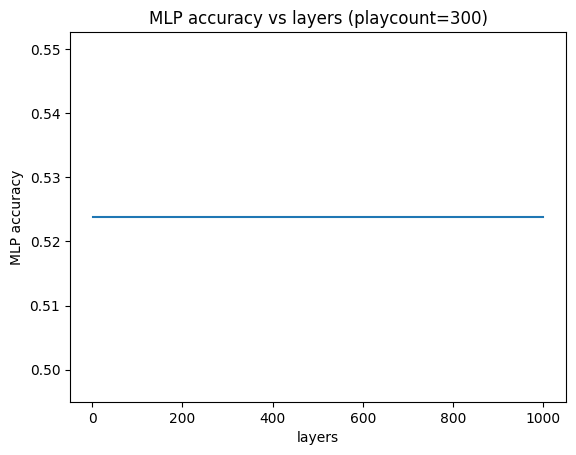

In [7]:
nodes = 2000
layers = 20

nodes_sweep = np.logspace(1, 4, num=4, base=10)*2
layers_sweep = np.logspace(0, 3, num=4, base=10)

accuracies_nodes = []

for layers in layers_sweep:

    h = (int(nodes),int(layers))
    activation='tanh'

    clf = MLPClassifier(hidden_layer_sizes=h,
                        activation=activation,
                        max_iter=10000, 
                        random_state=0).fit(X_train, y_train)

    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies_nodes.append(acc)

    print(f'h={h} | accuracy = {100*acc}\n')

    test_predictions = [results[i] for i in preds]

    for i in range(tts_idx, game_count): # indexing only the test data
        print(f'{game_summaries[i]} ||| Prediction: {name_to_abbr(team)} {test_predictions[i-tts_idx]}')
        
        
fig = plt.figure()
ax = plt.axes()
ax.plot(layers_sweep, accuracies_nodes)
plt.xlabel('layers')
plt.ylabel('MLP accuracy')
plt.title(f'MLP accuracy vs layers (playcount={playcount_stopper})')
plt.show()    

h=(20, 20) | accuracy = 52.38095238095239

2021-05-16: CLE @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-03-19: BRK @ ORL | winner: ORL ||| Prediction: BRK WIN
2021-01-03: WAS @ BRK | winner: WAS ||| Prediction: BRK WIN
2021-04-18: BRK @ MIA | winner: MIA ||| Prediction: BRK WIN
2021-04-30: POR @ BRK | winner: POR ||| Prediction: BRK WIN
2021-04-29: BRK @ IND | winner: BRK ||| Prediction: BRK WIN
2021-01-08: BRK @ MEM | winner: MEM ||| Prediction: BRK WIN
2021-04-23: BOS @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-03-17: BRK @ IND | winner: BRK ||| Prediction: BRK WIN
2021-02-13: BRK @ GSW | winner: BRK ||| Prediction: BRK WIN
2021-05-04: BRK @ MIL | winner: MIL ||| Prediction: BRK WIN
2021-03-01: BRK @ SAS | winner: BRK ||| Prediction: BRK WIN
2021-04-07: NOP @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-04-16: CHO @ BRK | winner: BRK ||| Prediction: BRK WIN
2021-05-12: SAS @ BRK | winner: BRK ||| Prediction: BRK WIN
2020-12-28: MEM @ BRK | winner: MEM ||| Prediction: BRK W

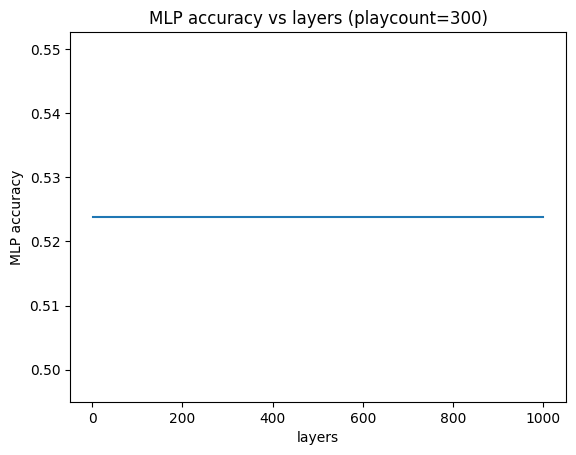

In [8]:
nodes = 2000
layers = 20

nodes_sweep = np.logspace(1, 4, num=4, base=10)*2
layers_sweep = np.logspace(0, 3, num=4, base=10)

accuracies_nodes = []

for nodes in nodes_sweep:

    h = (int(nodes),int(layers))
    activation='tanh'

    clf = MLPClassifier(hidden_layer_sizes=h,
                        activation=activation,
                        max_iter=10000, 
                        random_state=0).fit(X_train, y_train)

    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies_nodes.append(acc)

    print(f'h={h} | accuracy = {100*acc}\n')

    test_predictions = [results[i] for i in preds]

    for i in range(tts_idx, game_count): # indexing only the test data
        print(f'{game_summaries[i]} ||| Prediction: {name_to_abbr(team)} {test_predictions[i-tts_idx]}')
        
        
fig = plt.figure()
ax = plt.axes()
ax.plot(layers_sweep, accuracies_nodes)
plt.xlabel('layers')
plt.ylabel('MLP accuracy')
plt.title(f'MLP accuracy vs layers (playcount={playcount_stopper})')
plt.show()    

In [9]:
# fig = plt.figure()
# ax = plt.axes()
# ax.plot(nodes_sweep, accuracies_nodes)
# plt.xlabel('nodes per hidden layer')
# plt.ylabel('MLP accuracy')
# plt.title(f'MLP accuracy vs nodes per hidden layer)')
# plt.show()

In [10]:
np.logspace(1, 4, num=4, base=10)*2

array([   20.,   200.,  2000., 20000.])

In [11]:
# s.shape[0] - s.iloc[:,2].dropna().shape[0]